In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import csv
import matplotlib.pyplot as plt
import itertools
import random

In [2]:
num_labels = 6
random.seed(0)

In [3]:
def load_frames(vid_path):
    frames = []
    
    imgs = os.listdir(vid_path)
    for i in range(len(imgs)):
        if i % 3 != 0:
            continue
        img_path = os.path.join(vid_path, imgs[i])
        frame = cv2.imread(img_path)
        # frame = cv2.resize(frame, (160, 90))

        # cv2.imshow("frame", frame)
        # cv2.waitKey(33)

        frames.append(frame)

    return frames


def extract_optical_flow(frames):
    features = []

    # 初始化前一帧
    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

    for frame in frames[1:]:
        # 將當前帧轉換為灰度圖
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 計算光流
        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # 將光流的水平和垂直分量組合為特徵向量
        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        # 更新前一帧
        prev_frame = gray

    return np.array(features)


def preprocess(path):
    vids = [[] for _ in range(num_labels)]
    with open(path + '.csv', 'r') as file:
        rows = csv.reader(file)
        for row in rows:
            vids[int(row[2])].append(row[0])
            
    features = []
    labels = []

    for l in range(num_labels):
        sampled_num = int(0.5 * len(vids[l]))
        sample_idx = [1] * sampled_num + [0] * (len(vids[l]) - sampled_num)
        random.shuffle(sample_idx)
        print(f"label {l}: {len(vids[l])} -> {sampled_num}")

        for i in range(len(vids[l])):
            if sample_idx[i] == 0:
                continue
            vid_path = os.path.join(path, vids[l][i])
            frames = load_frames(vid_path)
            optical_flow_features = extract_optical_flow(frames)
            # print(optical_flow_features.shape)
            features.append(optical_flow_features)
            labels.append(l)    

    return np.array(features), np.array(labels)

In [4]:
X_train, y_train = preprocess('./train_aug')
print(X_train.shape, y_train.shape)
X_test, y_test = preprocess('./val_aug')
print(X_test.shape, y_test.shape)

label 0: 1591 -> 795
label 1: 1550 -> 775
label 2: 1346 -> 673
label 3: 1224 -> 612
label 4: 1795 -> 897
label 5: 1876 -> 938
(4690, 9, 28800) (4690,)
label 0: 398 -> 199
label 1: 388 -> 194
label 2: 337 -> 168
label 3: 306 -> 153
label 4: 449 -> 224
label 5: 470 -> 235
(1173, 9, 28800) (1173,)


In [5]:
"""
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# 创建 SVM 模型
svm_model = SVC()

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train_flat, y_train)

# 打印最佳参数和最佳分数
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
"""

'\n# 將三維特徵數組轉換為二維\nX_train_flat = X_train.reshape((X_train.shape[0], -1))\nX_test_flat = X_test.reshape((X_test.shape[0], -1))\n\nparam_grid = {\'C\': [0.1, 1, 10, 100], \'kernel\': [\'linear\', \'rbf\', \'poly\', \'sigmoid\']}\n\n# 创建 SVM 模型\nsvm_model = SVC()\n\n# 使用 GridSearchCV 进行参数搜索\ngrid_search = GridSearchCV(svm_model, param_grid, cv=5)\ngrid_search.fit(X_train_flat, y_train)\n\n# 打印最佳参数和最佳分数\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n'

In [6]:
# 將三維特徵數組轉換為二維
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

svm_model = SVC(kernel='linear', C=0.1)

# 訓練SVM模型
svm_model.fit(X_train_flat, y_train)

# 在測試集上進行預測
y_pred = svm_model.predict(X_test_flat)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5609548167092924


In [7]:
cnf_matrix_sklearn = confusion_matrix(y_test, y_pred)
print(cnf_matrix_sklearn)

[[123  14  24   4   2  32]
 [ 39 127  15   2   4   7]
 [ 30  12  95   1   0  30]
 [ 32  34   5  59  12  11]
 [ 37  52   4  23 104   4]
 [  2   8  20  10  45 150]]


In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[123  14  24   4   2  32]
 [ 39 127  15   2   4   7]
 [ 30  12  95   1   0  30]
 [ 32  34   5  59  12  11]
 [ 37  52   4  23 104   4]
 [  2   8  20  10  45 150]]


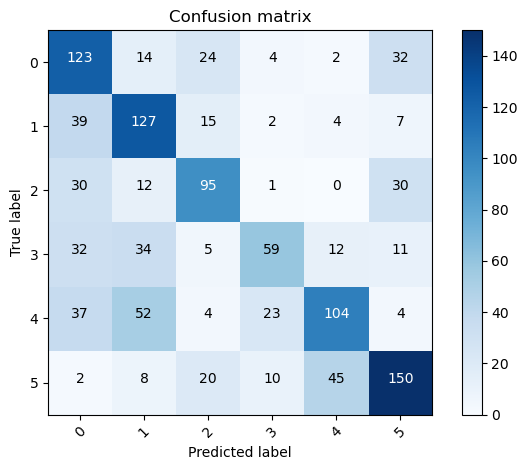

In [9]:
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)